In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cvx_portfolio.costs import TcostModel
from cvx_portfolio.simulator import MarketSimulator
from cvx_portfolio.policies import Hold,PeriodicRebalance

plotdir = '../portfolio/plots/'
datadir= '../equity_data_tool/'

## Download data using ee103 code (to be integrated) 

In [2]:
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])
#prices=pd.read_csv(datadir+'prices.txt',index_col=0,parse_dates=[0])

spread = pd.DataFrame(data=2.5*1e-4, index=volumes.index, columns=volumes.columns)
nonlin_coeff = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns) # fix volatility model

## Simulations

In [3]:
import pandas as pd

from cvx_portfolio.costs import TcostModel
from cvx_portfolio.simulator import MarketSimulator
from cvx_portfolio.policies import Hold,PeriodicRebalance

simulated_tcost = TcostModel(volumes, sigmas, spread, nonlin_coeff, cash_key='USDOLLAR')
simulator = MarketSimulator(returns, volumes, [simulated_tcost], cash_key='USDOLLAR')

benchmark = pd.Series(index=returns.columns, data=1)/len(returns.columns)
benchmark.USDOLLAR = 0.
benchmark/=sum(benchmark)

def select_starts_periods(period_property, timestamps):
    selected = [timestamps[0]]
    for day in timestamps[1:]:
        if not (period_property(day) == period_property(selected[-1])):
            selected.append(day)
    return selected

policies = []
for selector in [lambda t: t.day,lambda t: t.week,lambda t: t.month,lambda t: t.quarter,lambda t: t.year]:
    policies.append(PeriodicRebalance(target=benchmark, rebalancing_times=select_starts_periods(selector,
                                                                                                returns.index)))
policies.append(Hold())

res = pd.DataFrame(index=['D','W','M','Q','A','H'])
for label, fund_val in [('\$100M',1E8), ('\$10B',1E10)]:
    res[label] = simulator.run_multiple_backtest(fund_val*benchmark, start_time="2012-01-01", 
                                     end_time="2016-12-31", policies=policies)

## Results 

In [29]:
table=pd.DataFrame()
table[r'Return']=res.applymap(lambda res: 100*res.mean_return).unstack()
table[r'Trans. costs']=\
    res.applymap(lambda res: (res.simulator_TcostModel.sum(1)/res.v).mean() * 100 * 250).unstack()
table[r'Active risk']= \
res.applymap(lambda res: np.std(returns.loc[returns.index>'2012-01-01'].mean(1) - res.returns)*100*np.sqrt(250)).unstack()

table_print=pd.DataFrame(table,copy=True)
table_print.ix[:,:]=table_print.ix[:,:].applymap(lambda x: r'%.2f%%'%x )
#table_print.ix[:,2:3]=table_print.ix[:,2:3].applymap(lambda x: r'%.2f b.p.'%x )

table_print

Return Trans. costs Active risk
\$100M D  16.95%        0.08%       0.13%
       W  17.01%        0.05%       0.15%
       M  17.02%        0.03%       0.22%
       Q  17.09%        0.02%       0.35%
       A  17.08%        0.01%       0.74%
       H  17.11%        0.00%       2.06%
\$10B  D  16.66%        0.37%       0.13%
       W  16.81%        0.24%       0.16%
       M  16.87%        0.18%       0.22%
       Q  16.98%        0.13%       0.35%
       A  17.02%        0.08%       0.75%
       H  17.11%        0.00%       2.06%

In [30]:
print(table_print.to_latex(float_format='%.2f', escape=False).replace('%',r'\%'))

\begin{tabular}{lllll}
\toprule
       &   &  Return & Trans. costs & Active risk \\
\midrule
\$100M & D &  16.95\% &        0.08\% &       0.13\% \\
       & W &  17.01\% &        0.05\% &       0.15\% \\
       & M &  17.02\% &        0.03\% &       0.22\% \\
       & Q &  17.09\% &        0.02\% &       0.35\% \\
       & A &  17.08\% &        0.01\% &       0.74\% \\
       & H &  17.11\% &        0.00\% &       2.06\% \\
\$10B & D &  16.66\% &        0.37\% &       0.13\% \\
       & W &  16.81\% &        0.24\% &       0.16\% \\
       & M &  16.87\% &        0.18\% &       0.22\% \\
       & Q &  16.98\% &        0.13\% &       0.35\% \\
       & A &  17.02\% &        0.08\% &       0.75\% \\
       & H &  17.11\% &        0.00\% &       2.06\% \\
\bottomrule
\end{tabular}



# Plots 

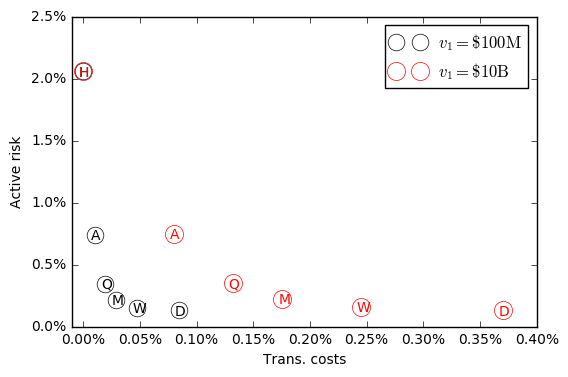

In [38]:
plt.figure(figsize=(6,4))
colors=['k','r']
offsetx = 0.0035
offsety = 0.04
data=table.ix[:,:]

for j,initval in enumerate(data.index.levels[0]):
    x=data.loc[initval].ix[:,1].values
    y=data.loc[initval].ix[:,2].values
    line,=plt.plot(x,y, colors[j]+'o', 
                   markersize=12+j,
                   fillstyle='none', 
                   label='$v_1 = %s\mathrm{%s}$'%(initval[:-1],initval[-1:]))
    for i in range(len(x)):
        plt.text(x[i]-offsetx,y[i]-offsety, data.index.levels[1][i],color=colors[j] )


plt.legend(loc='upper right')
plt.ylabel(r'Active risk')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter( '%.2f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter( '%.1f%%'))


# fmt = '%d b.p.' # Format you want the ticks, e.g. '40%'
# yticks = mtick.FormatStrFormatter(fmt)
# ax.yaxis.set_major_formatter(yticks)


#ax.xaxis.set_label_coords(.5, -0.065)
plt.xlabel(r'Trans. costs')
plt.xlim([-0.01,0.4])
#plt.ylim([- 0.5, 14])
plt.savefig(plotdir+'basic_frontier.png')

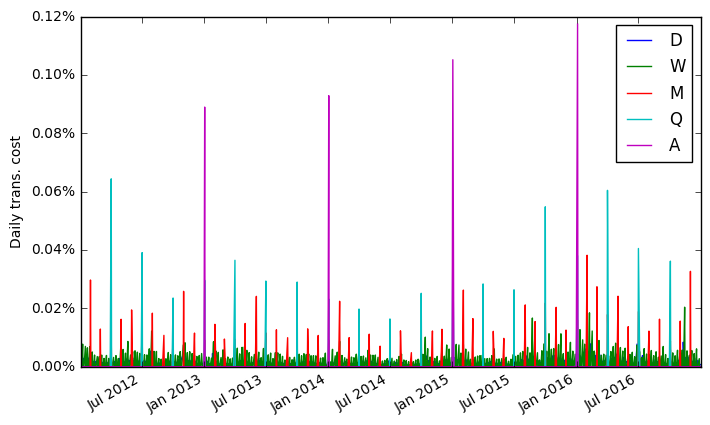

In [28]:
res.loc[:, '\$10B'].apply(lambda x: 100*x.simulator_TcostModel.sum(1)/x.v).T.ix[:,:-1].plot(figsize=(8,5))
import matplotlib.ticker as mtick
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f%%'))

#plt.ylabel("$\phi_t^{\mathrm{trade}}(z_t)$",fontsize=20)
plt.ylabel("Daily trans. cost")

plt.savefig(plotdir+'basic_example_tcost_time.png')

In [9]:
# for k,results in res.loc['D'].iteritems():
#     plt.figure()
#     (100*(results.v-results.initial_val)/results.initial_val).plot(label='Profit (%)')
#     (100*(-results.simulator_TcostModel.sum(1).cumsum())/results.initial_val).plot(style='r',label='T. costs (%)')
#     plt.legend(loc='upper left')
#     plt.title('%s uniform portfolio daily rebalance simulation'%k)
#     plt.savefig(plotdir+'%s_pandl_tcost_tseries.png'%k[1:])